In [120]:
import numpy as np
import pandas as pd
import operator
import itertools
import seaborn as sns
import matplotlib as mpl
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import euclidean_distances, silhouette_score

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

rcParams['figure.figsize'] = 15, 5
import os 
path = os.chdir('C:\\Users\\akhil\\Downloads\\BI\\2 Clustering')

## Case Overview:

- The given problem is based on unsupervised learning.
- The client has some data containing several research papers scrapped from the web and they want our help to organise all of them and group the papers by keywords or groups.
- This inturn would help them to run separate ads on social media and use SEO to target the respective keywords within them.
- One thing has to be kept in mind which is to make minimal numbers of cluster as there are distinct values within keywords and group features, thus they would result in many clusters of SEO keywords.



In [138]:
data = pd.read_csv('Research papers.csv')
data.head()

,title,authors,groups,keywords,topics,abstract
0,Kernelized Bayesian Transfer Learning,Mehmet Gönen and Adam A. Margolin,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Transfer learning considers related but distin...
1,"""Source Free"" Transfer Learning for Text Class...","Zhongqi Lu, Yin Zhu, Sinno Pan, Evan Xiang, Yu...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Transfer learning uses relevant auxiliary data...
2,A Generalization of Probabilistic Serial to Ra...,Haris Aziz and Paul Stursberg,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,The probabilistic serial (PS) rule is one of t...
3,Lifetime Lexical Variation in Social Media,"Liao Lizi, Jing Jiang, Ying Ding, Heyan Huang ...",NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,As the rapid growth of online social media att...
4,Hybrid Singular Value Thresholding for Tensor ...,"Xiaoqin Zhang, Zhengyuan Zhou, Di Wang and Yi Ma",Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...,"In this paper, we study the low-rank tensor co..."


- We are only going to deal with 4 feaures in our case which are title, groups, keywords,topics as Authors and Abstract field are too detailed in nature.

In [139]:
data_train = data[['title', 'groups', 'keywords', 'topics']]

In [140]:
print(data_train.shape)
print('\n')
print(data_train.info())

(398, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     398 non-null    object
 1   groups    396 non-null    object
 2   keywords  398 non-null    object
 3   topics    394 non-null    object
dtypes: object(4)
memory usage: 12.6+ KB
None


In [141]:
data_train.isnull().sum()

title       0
groups      2
keywords    0
topics      4
dtype: int64

## Approach to solve this problem:

- 

In [145]:
#Stretching the Data Frame Row-wise as a Function of Groups
s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']

In [146]:
data_train = data_train.join(s).reset_index()

In [147]:
data_train['flags'] = pd.Series(np.ones(len(data_train)), index=data_train.index)
data_train

,index,title,keywords,topics,flags,groups
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,1.0,Novel Machine Learning Algorithms (NMLA)
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,1.0,AI and the Web (AIW)
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,1.0,Novel Machine Learning Algorithms (NMLA)
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,1.0,Game Theory and Economic Paradigms (GTEP)
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,1.0,NLP and Text Mining (NLPTM)
...,...,...,...,...,...,...
672,393,Mapping Users Across Networks by Manifold Alig...,Social Networks\nManifold Alignment\nHypergrap...,AIW: Machine learning and the web\nAIW: Ontolo...,1.0,AI and the Web (AIW)
673,394,Compact Aspect Embedding For Diversified Query...,query expansion\nsearch result diversification...,AIW: Enhancing web search and information retr...,1.0,AI and the Web (AIW)
674,395,Contraction and Revision over DL-Lite TBoxes,Belief Change\nDescription Logic\nNon-monotoni...,KRR: Belief Change\nKRR: Description Logics\nK...,1.0,Knowledge Representation and Reasoning (KRR)
675,396,Zero Pronoun Resolution as Ranking,Zero Pronouns\nText Mining\nNatural Language P...,NLPTM: Evaluation and Analysis,1.0,NLP and Text Mining (NLPTM)


In [148]:
# Adding a Function for Matrix Creation

def matrix_from_df(data_train):
    matrix = data_train.pivot_table(index=['title'], columns=['groups'], values='flags')
    matrix = matrix.fillna(0).reset_index()
    x_cols = matrix.columns[1:]
    return matrix, x_cols

## Clustering 

- We are going to use clustering algorithm for this problem. 
- K-means will be a iable solution for this problem.
- After modelling we will evaluate our model using:
    - Elbow Method
    - Variance Explained
    - BIC Score
    

### Applying Elbow Method and Variance Explained on Data Matrix

C:\Users\akhil\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0.5, 1.0, 'Elbow for KMeans clustering')

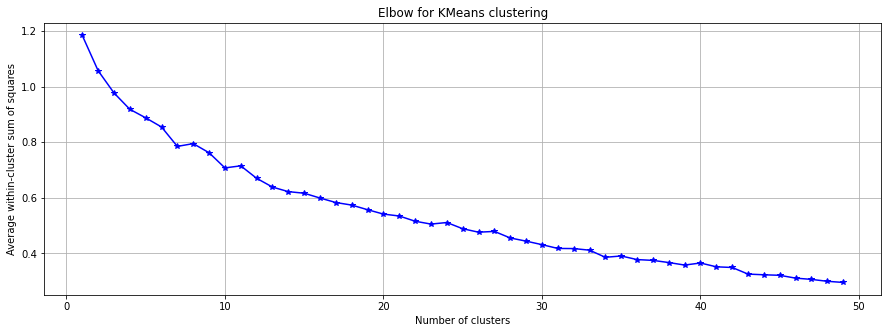

In [149]:

# Retrieve Matrix and x cols from the matric_from_df Method

matrix,x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

#training 49 models of k-means in clustering, each having different value of K ranging from 1 to 50.
#Then we will fetch the cluster centers for those clustering models and determined the cluster memberships for each of these 
#resarch papers model by model.
K = range(1,50) 
KM = [KMeans(n_clusters=k).fit(X) for k in K] 
centroids = [k.cluster_centers_ for k in KM]


#Finally, for each model,we computed the sum of all research papers and divided it by the total number of research papers to get the 
#average within cluster sum of squares. 
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D, axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]


#plotted the cluster sum of squares for all of the 49 cluster models to formulate the Elbow method.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

- __As per the figure above we can deduce the elbow to occur at k=9.__

- But is it enough to draw conclusion about our final result ? I dont think so, that's why we will use other methods to analyse our model as well so that we can have homogeniouty in our results and nuild a strong conclusion.

### Applying Elbow Method and Variance Explained to Data Matrix



C:\Users\akhil\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Text(0.5, 1.0, 'Elbow for KMeans clustering')

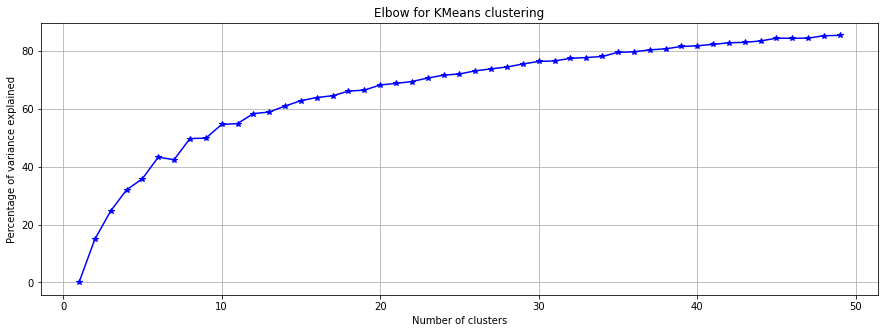

In [150]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

#This step is same as we did in the elbow method cell
K = range(1,50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D, axis=1) for D in D_k]

#After getting the cluster memberships of each research paper cluster by cluster, the distances were then used to compute the 
#within cluster sum of square. 
wcss = [sum(d**2) for d in dist]

# Next, distances were computed among the columns within each research paper to compute the total sum of squares. 
tss = sum(pdist(X)**2)/X.shape[0]

#Finally, within the cluster sum of square was subtracted from total sum of squares to get the between sum of squares
bss = tss - wcss

kIdx = 10-1

#Ratio of between sum of squares and total sum of squares was taken to plot in Figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

__We can observe that the gradient to start smoothing from k = 9, similar to what he had observered with the Elbow method.__

###  Plotting Silhouette Score Plot from the Data Matrix

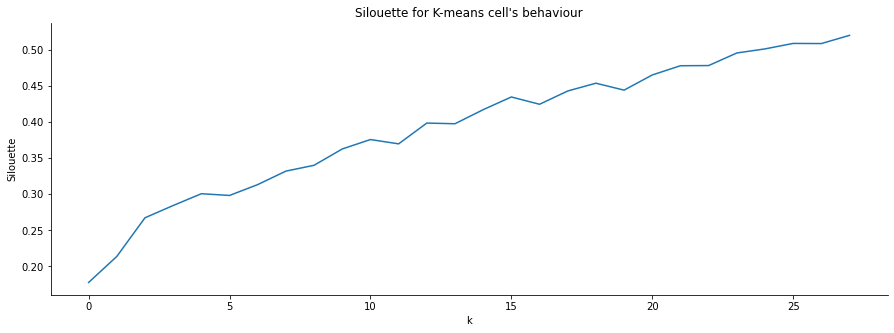

In [151]:
s = []

for n_clusters in range(2,30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    s.append(silhouette_score(X, labels, metric='euclidean'))
    
plt.plot(s)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

- 27 clusters is way too many for a data matrix having 398 observations in total
- So what should we do ? 

### APPLYING K-MEANS CLUSTERING FOR OPTIMAL NUMBER OF CLUSTERS

In [152]:
# Training k-means Model for Cluster Size of 9

matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]

cluster = KMeans(n_clusters = 9, random_state = 2)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

0    81
1    78
5    44
3    38
6    36
2    32
8    30
7    30
4    27
Name: cluster, dtype: int64

__Our findings:__

- We can see that except for two clusters, which had 80 observations each, the remaining seven clusters had 30 observations each on average.
- Lets visualize all these clusters using PCA.
- We are  going to reduce the group dimensions to two dimensions (i.e., x, and y). 
- It will be easy for hus to plot the clusters on a two-dimensional axis.

In [153]:
# Using PCA to Transform Group-Related Features into Two Components
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:,0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:,1]
matrix = matrix.reset_index()

customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",1,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,8,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",4,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,2,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,3,0.198578,-0.129668


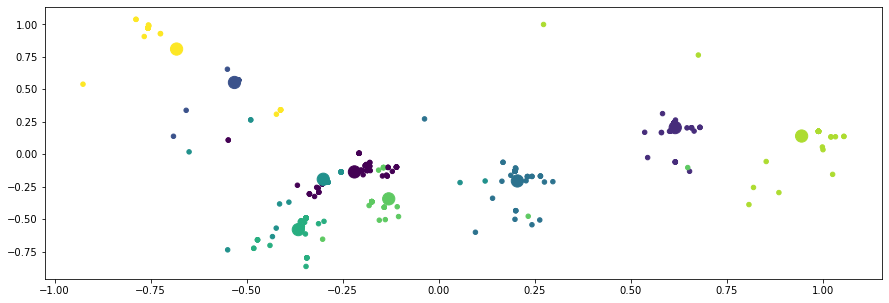

In [154]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))

plt.scatter(customer_clusters['x'], customer_clusters['y'], s = 20, c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s = 150, c=cluster_centers['cluster'])

- Cluster memberships in Figure above seemed  to be distinct and non-overlapping.
- However our initially laid out objective was to find similar keywords associated within each segment.
- For this purpose we are going to take some help from wordcloud

In [88]:
# Merging Matrix into the Original Data Frame
customer_clusters.columns.name = None
df = data_train.merge(customer_clusters, on='title')
df.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,1,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,1,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,1,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,2,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,0,-0.183192,-0.090091


In [91]:
# df.drop('index', axis=1, inplace=True)

- A wordcloud will show all words associated with a given cluster, with the word font sizes representing their frequency of occurrence within the pivotal feature

In [155]:
def wordcloud_object(word_string):

    wordcloud = WordCloud(font_path='C:\\Users\\akhil\\Downloads\\BI\\2 Clustering\\arial.ttf',stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud

# Creating Function to Plot Wordcloud for Each Cluster
def plot_wordcloud(df, clusters, pivot):

    fig = plt.figure(figsize=(15,29.5))
    for cluster in range(clusters):
        List = []

        for x in df[df['cluster']==cluster][pivot]:
            try:
                List.extend(x.split('\n'))
            except:
                pass

        if List:
            ax = fig.add_subplot(5,2,cluster+1)
            wordcloud = wordcloud_object(List)
            plt.title('Cluster: %d'%(cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')

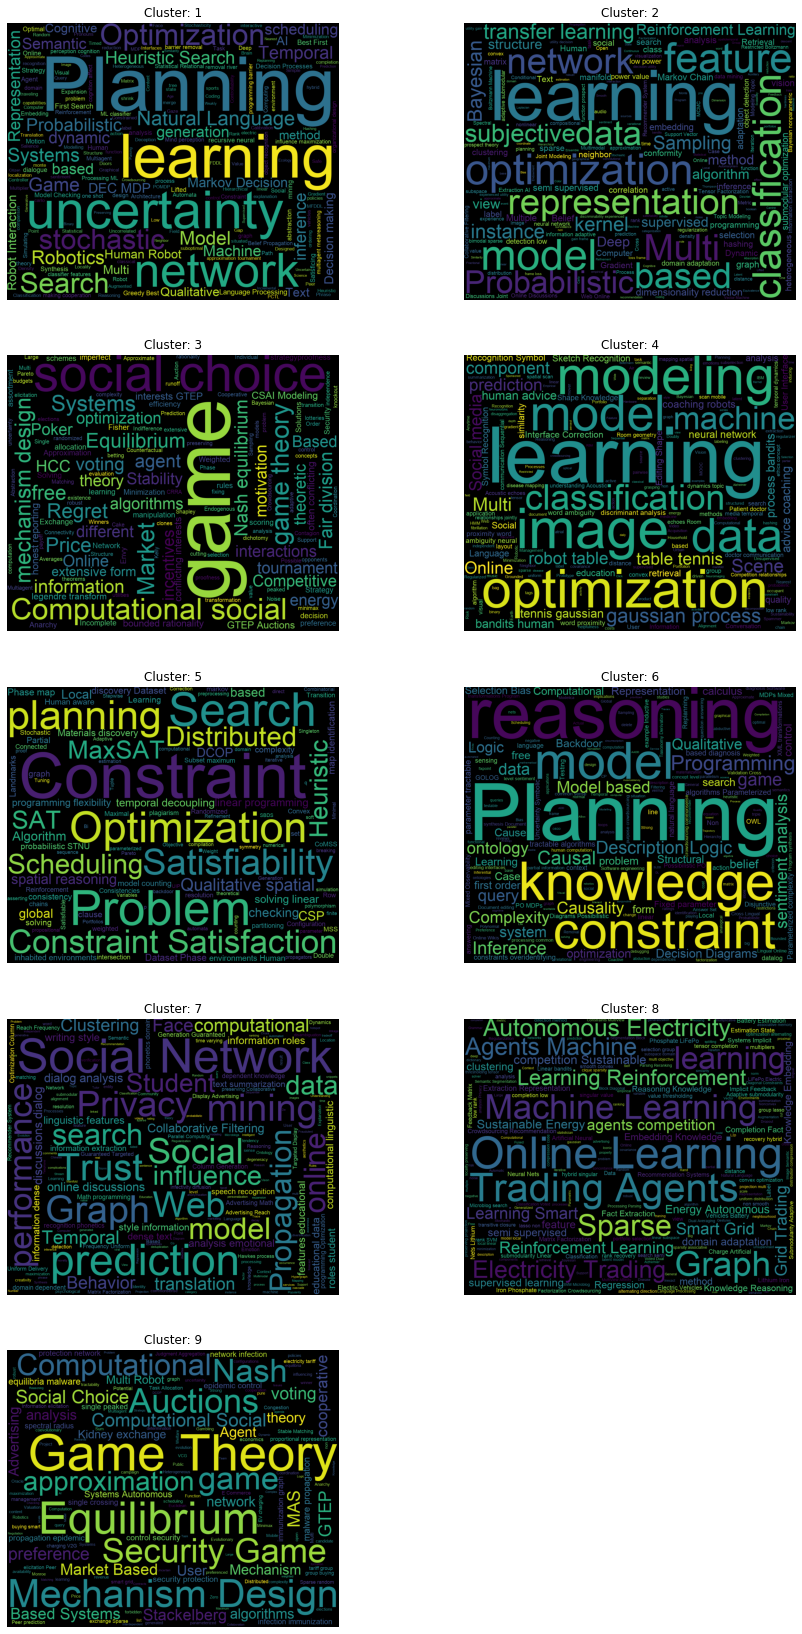

In [102]:
# Generating Wordclouds of Feature Named ‘Keywords’
plot_wordcloud(df, cluster.n_clusters, 'keywords')

#### After looking at Figure above, we can define the nine clusters as follows:

- __Cluster 1:__ Papers talking about search and robotics

- __Cluster 2:__ Papers talking in depth about models’ learning and optimization

- __Cluster 3:__ Topics of application of data analytics in games and social media analytics

- __Cluster 4:__ Topics of image recognition, robotics, and social media analytics

- __Cluster 5:__ Topics of linear programming and search

- __Cluster 6:__ Papers on reasoning-based models

- __Cluster 7:__ Papers on application of data sciences in social graphs and other online mediums

- __Cluster 8:__ Topics ranging in knowledge graphs

- __Cluster 9:__ Papers concentrating on game theory and data security

__Our findings:__

- Some clusters had overlapping terms; for instance, clusters 1 and 5 had “search” as the overlapping term. 
- This is not good, as we want to remove the overlap to make the cluster keywords and characteristics as distinctive as possible.
- Lets check it out wether other clusters have overlapping topics or not 


In [157]:
# Define Method to Find Complete Keywords for Given Clusters and Unigram

def perform_cluster_group_audit(clusters, term):

    for cluster in clusters:

        df_cluster = df[df['cluster'] == cluster]
        print('Cluster number: %d'%(cluster + 1))
        keywords = list(df_cluster['keywords'])
        keywords = [keyword.split('\n') for keyword in keywords]
        keywords = [item for sublist in keywords for item in sublist]
        keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]
        keywords_freq = {x:keywords.count(x) for x in keywords}
        print(sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True))
        print('\n')
              

In [158]:
df['keywords'][3]

'social choice theory\nvoting\nfair division\nsocial decision schemes'

In [159]:
#Find Keywords for 'Search' in clusters 0 and 4

perform_cluster_group_audit([0,4], 'search')

# Using Function to Find Keywords for Social in Clusters 2, 3, and 6

perform_cluster_group_audit([2,3,6], 'social')

Cluster number: 1
[('heuristic search', 7), ('greedy best first search', 4), ('monte carlo tree search', 2), ('similarity search', 1), ('approximate nearest neighbor search', 1), ('incremental search', 1), ('real-time search', 1), ('agent-centered search', 1), ('hierarchical search', 1), ('parallel search', 1), ('bounded suboptimal search', 1), ('best-first search', 1), ('suboptimal heuristic search', 1)]


Cluster number: 5
[('heuristic search', 3), ('search', 3), ('local search', 2), ('stochastic local search', 2), ('and/or search', 2)]


Cluster number: 3
[('computational social choice', 11), ('social choice theory', 2), ('social decision schemes', 2), ('randomized social choice', 1)]


Cluster number: 4
[('social media', 5), ('social spammer', 2), ('social image classification', 2)]


Cluster number: 7
[('social networks', 6), ('social infectivity', 3), ('social network', 3), ('location based social network', 2), ('social network analysis', 2), ('social influence', 2), ('social dyn

__Our Findings:__
- We can observe that cluster 5 had topics on local search and cluster 1 had topics on other search algorithms.
- Cluster 3 emphasized social choice theories.
- Cluster 4, on the other hand, concentrated on social images classification and social spamming.]
- Cluster 7 grouped research papers related to social graphs and influences among interconnections.

## Gaussian Mixture Model

- Gaussian mixture models use probabilistic theory to estimate the number of clusters the data can be divided into. 
-  It works on the assumption that all data points are generated from the mixture of finite number of Gaussian distributions with unknown parameters.
- Gaussian mixture models can be thought as an enhancement to k-means where the covariance of the data and centers of Gaussian models are taken into consideration.

### Gaussian mixture model comes in the following variants to constrain the covariance of different cluster estimates:

- Spherical

- Diagonal

- Tied

- Full covariance
</br>

### Defining Function to Plot the Clusters
- Lets apply Gaussian mixture models to find out the segments and their characteristics. 
- For this purpose we will write a function to generate a scatter plot of clusters generated from Gaussian mixture models.

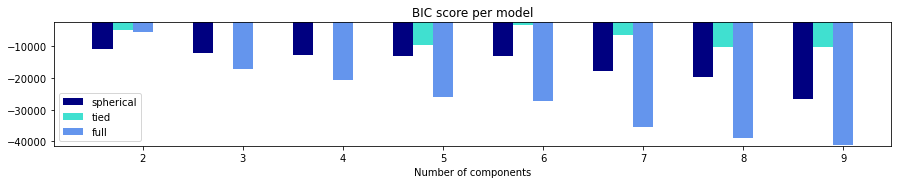

In [160]:
# Determining the Optimal Covariance Type and Components for Model and Plotting It

matrix, x_cols = matrix_from_df(data_train)
X  = matrix[x_cols].to_numpy()
model_stats = []
n_components_range = range(2, 10)
cv_types = ['spherical', 'tied', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:

        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type, random_state=0)
        gmm.fit(X)
        model_stats.append({'name':'%s_%d'%(cv_type, n_components), 'model':gmm, 'bic':gmm.bic(X)})

bic = np.array([m_type['bic'] for m_type in model_stats])
best_gmm = model_stats[bic.argmax()]
clf = best_gmm['model']
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue'])

bars = []

# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

labels = clf.predict(X)

__Our Findings:__

- We can observe that the values within figure are of negative magnitude.
- Therefore, a covariance type and number of components at 0 will be deemed the winner.
- A gaussian mixture model with covariance type 'tied' and three components qualified to be the winner in this case.

In [169]:
#Display Frequency of Objects in Each Cluster
matrix['cluster'] = labels
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),Humans and AI (HAI),Knowledge Representation and Reasoning (KRR),Machine Learning Applications (MLA),Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS),cluster
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [176]:
# Merging Matrix into the Initial Data Frame
customer_clusters.columns.name = None
matrix.columns.name = None
df_2 = data_train.merge(matrix, on='title')

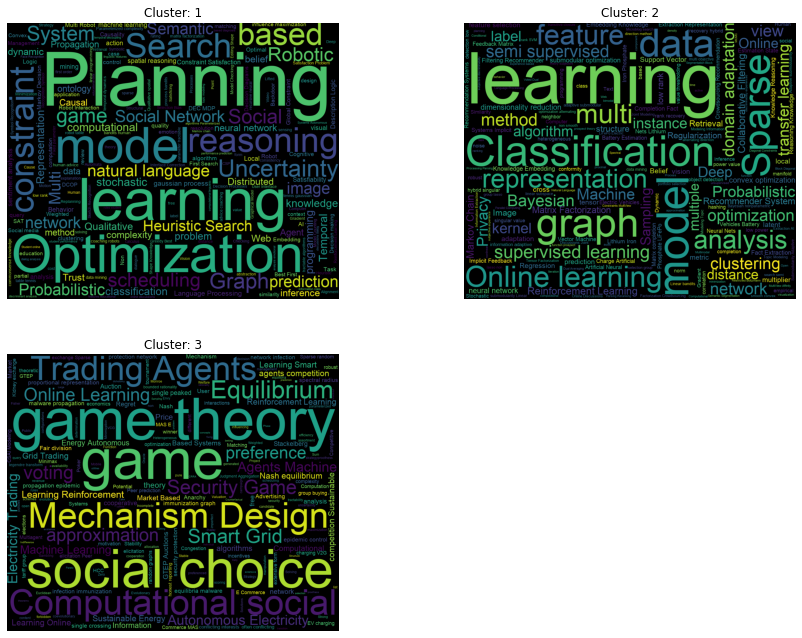

In [178]:
#Generating Wordclouds of Feature Named “Keywords ”
plot_wordcloud(df_2, gmm.n_components, 'keywords')

#### After looking at Figure above, we can define the three clusters as follows:

- __Cluster 1:__ Papers discussing in depth models’ learning and linear programming

- __Cluster 2:__ Papers discussing in depth model optimization and knowledge graphs

- __Cluster 3:__ Topics on game theory and social media analytics]


#### The results are better now, as these clusters seemed to be unique in terms of their characteristics.

However, is there any algorithm to automatically determine the optimal number of components ?
Actually there is let's use __Bayesian Gaussian mixture__ model for this.

So, What is Bayessian Gaussian Mixture model ?
- The Bayesian Gaussian mixture model is a variant of the Gaussian mixture model in which the model chooses the optimal number of clusters on its own.
-  It exhibits this behavior when weight_concentration_prior is set to be small enough and n_components is set to be larger than what is found necessary by the model.
- The variational Bayesian mixture model sets some mixture weight values close to zero, which lets the model choose effective components automatically. </br>

### Training the Model and Plotting the Clusters


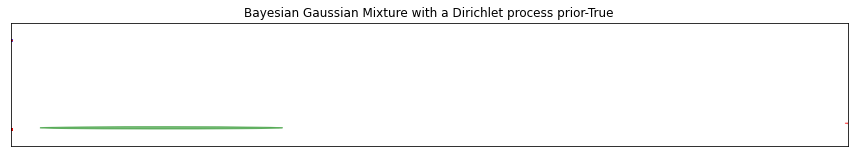

In [184]:
matrix, x_cols = matrix_from_df(data_train)
X  = matrix[x_cols].to_numpy()

dpgmm = mixture.BayesianGaussianMixture(n_components=3,
                                        covariance_type='full', random_state=1).fit(X)

labels = dpgmm.predict(X)
plot_results(X, labels, dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior-%s'%dpgmm.converged_)

plt.show()

In [185]:
# Display Frequency of Objects in Each Cluster
matrix['cluster'] = labels
matrix.cluster.value_counts()

0    229
1    117
2     50
Name: cluster, dtype: int64

In [186]:
#Merging Matrix into the Initial Data Frame
matrix.columns.name = None
df_3 = data_train.merge(matrix, on='title')

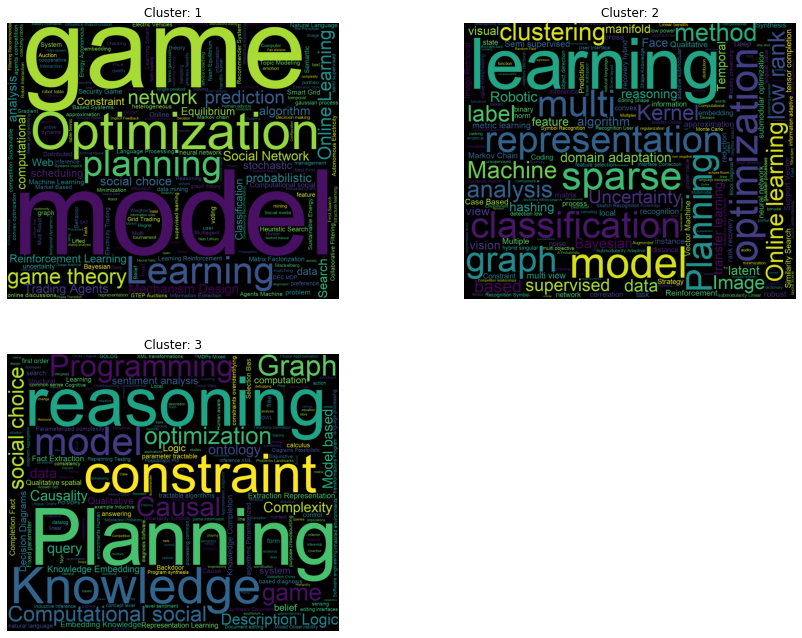

In [187]:
plot_wordcloud(df_3, dpgmm.n_components, 'keywords')

#### After looking at Figure above, we can define the three clusters as follows:

- __Cluster 1:__  Papers discussing in depth game theory and social media analytics

- __Cluster 2:__  Papers discussing in depth model optimization and models’ learning

- __Cluster 3:__  Topics on linear programming, knowledge graphs, and reasoning-based models

__Final Outcome:__

- After going through the whole caseI think we were able to get finite clusters with distinct characteristics. 
- In addition I think its best to drop the output of k-means and go forward with the segments defined by the Bayesian Gaussian mixture model because clusters made by __Bayesian Gaussian mixture made more intuitive sense, and second, that it was smart enough to find the optimal number of clusters all on its own.__